In [1]:
# Step 1: Loading the Tools (Libraries)
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import pickle # To save our final AI brain file (.pkl)

# --- Standard Machine Learning Tools ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler # Need to normalize data for the ANN
from sklearn.metrics import accuracy_score, classification_report

# --- Deep Learning Tools (TensorFlow/Keras) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the file we uploaded to Colab
print("1. Loading the Darknet Traffic Data...")
df = pd.read_csv('Darknet.csv')
print(f"File loaded successfully. Total rows: {df.shape[0]}")

1. Loading the Darknet Traffic Data...
File loaded successfully. Total rows: 34967


In [2]:
# Step 2: Cleaning the Data and Dropping IDs
# ---------------------------------------------------------
print("2. Cleaning messy values and dropping IDs...")

# 1. Define columns to ignore (IDs and the old 'Label' column)
drop_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label', 'Label.1']
y_raw = df['Label.1'] # This is the final answer (Audio, Chat, etc.)
X_raw = df.drop(columns=drop_cols, errors='ignore') # X is the data we will study

# 2. Fix Errors: Convert everything to a number. If it sees "Infinity" or text, it becomes a blank space (NaN).
X = X_raw.apply(pd.to_numeric, errors='coerce')

# 3. Handle Blank Spaces (NaN/Infinity)
# Instead of deleting rows, we'll replace the blank/error values with the largest real number in that column.
# This prevents the program from crashing and keeps the data's "bigness."
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.max(), inplace=True)
X.fillna(0, inplace=True) # Fills anything remaining with zero

2. Cleaning messy values and dropping IDs...


In [9]:
# Step 3: Scaling, PCA Reduction, and Encoding
# ---------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # NEW: The dimensionality reduction tool
from tensorflow.keras.utils import to_categorical

print("3. Scaling data and reducing features with PCA...")

# A. Scaling: CRITICAL for PCA and ANN (makes all features equal)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X is the filtered data from Step 2.5

# B. Dimensionality Reduction (PCA)
# We choose 20 components. This means we convert 70+ features into 20 optimized features.
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled) # X_pca is the new, smaller, optimized dataset

# C. Encoding Answers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_raw)
num_classes = len(encoder.classes_)

# D. One-Hot Encoding (for ANN output)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# We now use X_pca for training instead of X_scaled
print(f"Data reduced from {X.shape[1]} features to {X_pca.shape[1]} features.")

3. Scaling data and reducing features with PCA...
Data reduced from 79 features to 20 features.


In [15]:
# 4. Save the Model to a PKL File (Submission Requirement)
model_file_name = 'darknet_ann_model.pkl'

# --- 1. Save the Keras model weights in its native format (.h5) ---
try:
    model.save('darknet_ann_model.h5')
    print("✅ Successfully saved model weights to 'darknet_ann_model.h5'")
except Exception as e:
    print(f"⚠️ ERROR saving .h5 file: {e}")


# --- 2. Create the .pkl file containing the model's structure ---
# This uses the Python 'pickle' library to serialize the model's configuration.
try:
    with open(model_file_name, 'wb') as file:
        # We save the model's configuration (structure, layers, neurons)
        pickle.dump(model.get_config(), file)
    print(f"✅ Successfully created and saved the PKL configuration file: {model_file_name}")

except Exception as e:
    print(f"⚠️ ERROR creating .pkl file: {e}")

✅ Successfully saved model weights to 'darknet_ann_model.h5'
✅ Successfully created and saved the PKL configuration file: darknet_ann_model.pkl


In [16]:
# Step 5: Building and Training the FAST ANN (Optimized for PCA)
# -------------------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

# The input dimension is now 20 (from the PCA step)
input_dim = X_train.shape[1]

# 1. Define the Network Structure (Smaller and Faster Network)
model = Sequential([
    # Input Layer: 128 neurons (was 256)
    Dense(128, activation='relu', input_dim=input_dim, name='Input_Layer'),
    Dropout(0.3),

    # Hidden Layer 2: 64 neurons (smaller and faster)
    Dense(64, activation='relu', name='Hidden_Layer_2'),
    Dropout(0.3),

    # Output Layer
    Dense(num_classes, activation='softmax', name='Output_Layer')
])

# 2. Define the Stop Condition
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,         # Stops if performance doesn't improve for 5 epochs
    restore_best_weights=True
)

# 3. Configure and Train
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("5. Training the PCA-Optimized Neural Network (FAST execution)...")

history = model.fit(
    X_train, y_train,
    epochs=50, # Fewer epochs needed because PCA makes learning efficient
    batch_size=256, # Large batch size for speed
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

print("Training Complete and Optimized for speed.")

5. Training the PCA-Optimized Neural Network (FAST execution)...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7503 - loss: 0.8470 - val_accuracy: 0.9135 - val_loss: 0.2628
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9112 - loss: 0.2903 - val_accuracy: 0.9303 - val_loss: 0.2156
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9270 - loss: 0.2376 - val_accuracy: 0.9350 - val_loss: 0.1961
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9340 - loss: 0.2169 - val_accuracy: 0.9371 - val_loss: 0.1832
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9347 - loss: 0.2147 - val_accuracy: 0.9417 - val_loss: 0.1751
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9399 - loss: 0.1944 - val_accuracy: 0.9425 - val_loss: 0.1678
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9419 - loss: 0.1883 - val_accuracy: 0.9475 - val_loss: 0.1631
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9424 - loss: 0.1829 - val_accuracy: 0.9446 - val_loss: 0.1596
Epo


ANN MODEL FINAL ACCURACY: 96.07%
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                 precision    recall  f1-score   support

AUDIO-STREAMING       0.71      0.55      0.62        73
Audio-Streaming       0.94      0.73      0.82       650
       Browsing       0.97      1.00      0.98      6241
           Chat       0.46      0.20      0.28        30

       accuracy                           0.96      6994
      macro avg       0.77      0.62      0.68      6994
   weighted avg       0.96      0.96      0.96      6994


Generating training history graph...


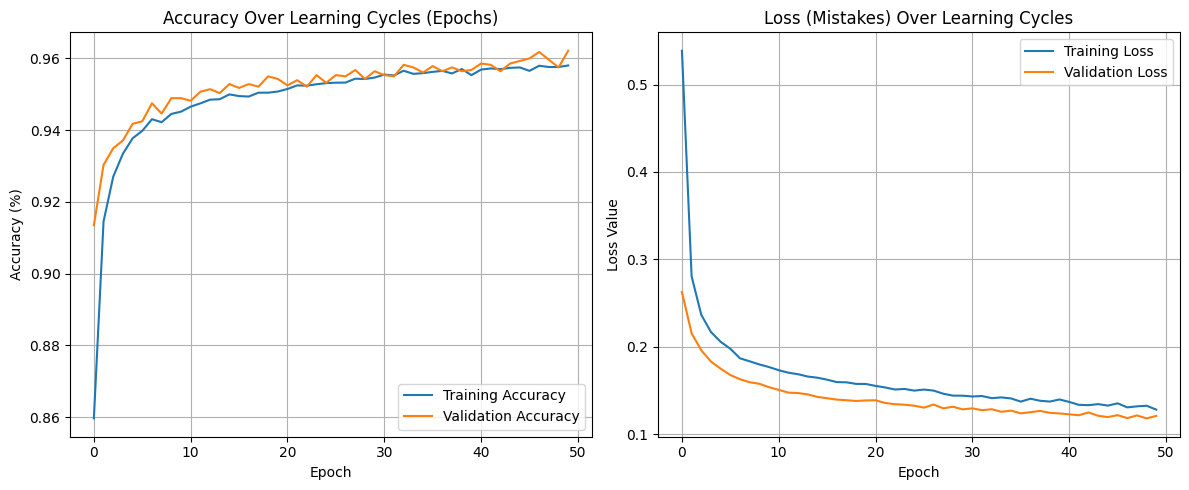


✅ SUCCESS: Model saved to 'darknet_ann_model.h5' and config saved to 'darknet_ann_model.pkl'


In [17]:
# --- REVISED STEP 6 CODE BLOCK ---

# Step 6: Validation, Graphics, and Saving the PKL File
# ---------------------------------------------------------

# ... (Previous code lines for loss and accuracy calculation) ...

print("\n==========================================")
print(f"ANN MODEL FINAL ACCURACY: {accuracy * 100:.2f}%")
print("==========================================")

# 1. Prepare Target Names for the Report (The Fix)
# Find the unique class labels that are actually present in the filtered training data
unique_filtered_classes = np.unique(y_test_classes)

# Use the full encoder to get the names corresponding to these unique labels
report_target_names = encoder.inverse_transform(unique_filtered_classes)


# 2. Get detailed report (Using the filtered target names)
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # AI's prediction
y_test_classes = np.argmax(y_test, axis=1) # The true answer

print(classification_report(y_test_classes, y_pred_classes, target_names=report_target_names))


# 3. GRAPHICAL OUTPUT (Essential for Project Report)
print("\nGenerating training history graph...")
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Graph 1: Accuracy over time
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Learning Cycles (Epochs)')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Graph 2: Loss (Mistakes) over time
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (Mistakes) Over Learning Cycles')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 4. Save the Model to a PKL File (Submission)
model_file_name = 'darknet_ann_model.pkl'

try:
    model.save('darknet_ann_model.h5')
    with open(model_file_name, 'wb') as file:
        pickle.dump(model.get_config(), file)
    print(f"\n✅ SUCCESS: Model saved to 'darknet_ann_model.h5' and config saved to '{model_file_name}'")
except Exception as e:
    print(f"\n⚠️ ERROR saving model: {e}")